# TP Keras (https://keras.io/)
Thomas Schmitt  
18 janvier 2017



" Keras is a high-level neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation "
Keras is used at Google with TensoFlow : http://www.fast.ai/2017/01/03/keras/

Why Kera : 
* used in Kaggle competition : https://pbs.twimg.com/media/C1bj1KcUsAAMv7-.jpg:large
* popularity on github https://pbs.twimg.com/media/Cz5pmafUUAAcvxf.jpg
* Also used in research paper : https://pbs.twimg.com/media/C1Mfr0vW8AAns2E.jpg:large




## Objectifs : 

Tester ce que l'on a vu dans les TP précédents :
    1. Softmax, SGD
    2. graph train/valid accuracy
    3. activation functions (tanh, relu, ...) 
    4. Deep
    5. Dropout
    6. Weights regularization
    
Puis essayer : 
    7. Optimizer : adam
    8. Earlystopping (callbacks) [https://keras.io/callbacks/#earlystopping]
    9. Visualize weigths evolution (e.g. while using or not weigths regularization) [cf handcraft callbacks]
    10. Visualize activation evolution (e.g. to detect saturation) [cf handcraft callbacks]
    
    11. Use convolutional layers (should change input format : https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py)
    

In [3]:
from __future__ import print_function, division, unicode_literals, generators, absolute_import
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils
from keras.objectives import  categorical_crossentropy
from keras.callbacks import Callback, EarlyStopping
from keras import backend as K
from keras.utils import np_utils


# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
nb_classes = 10
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
60000 train samples
10000 test samples


array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

# Model

In [6]:
def loss_fct(y_true, y_pred):
    
    
    # l2 = 0.001 * (model.layers[0].W**2).sum()
    l2 = 0
    return categorical_crossentropy(y_true, y_pred) + l2
    


In [29]:
def model_keras():

    """ return a NN model """
    model = Sequential()

    model.add(Dense(800, input_shape=(784,), activation='relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(800, activation='tanh'))
    #model.add(Dropout(0.8))
    model.add(Dense(10, activation='softmax'))
    
    
    
    model.compile(loss=loss_fct,
              optimizer='adam', #'adam'
              metrics=['accuracy'])
        
    model.summary()    
    return model

model = model_keras()



batch_size = 128
nb_epoch = 5

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    callbacks=[],
                    verbose=1, validation_data=(X_test, Y_test))

score = model.evaluate(X_test, Y_test, verbose=1)
print()
print('Test score:', score[0] ) # loss 
print('Test accuracy:', score[1]) 


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_46 (Dense)                 (None, 800)           628000      dense_input_20[0][0]             
____________________________________________________________________________________________________
dense_47 (Dense)                 (None, 800)           640800      dense_46[0][0]                   
____________________________________________________________________________________________________
dense_48 (Dense)                 (None, 10)            8010        dense_47[0][0]                   
Total params: 1,276,810
Trainable params: 1,276,810
Non-trainable params: 0
____________________________________________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 20s - los

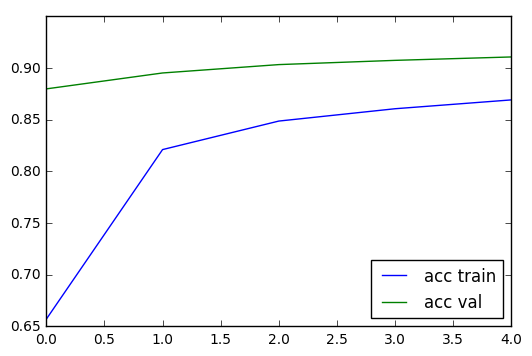

In [26]:
plt.plot(history.history['acc'],label = 'acc train')
plt.plot(history.history['val_acc'],label = 'acc val')
plt.legend(loc = 4)

### Advanced Callback

In [5]:
## advanced callback 

class WeightNorm(Callback):

    """ callback object """
    def __init__(self):
        pass

    def on_epoch_end(self, epoch, logs={}):
        """ run it at every epoch's end """
        
        m = self.model
        pred_layer_1 = K.function([m.layers[0].input, K.learning_phase()], [m.layers[1].output])
        act_layer_1, = pred_layer_1([X_train[0:100], 1])
        median_act_layer_1 = np.median(act_layer_1)
        
        norm_W0 = np.sqrt(((self.model.layers[0].W.get_value())**2).sum())
        
        # add info in the logs variable. Which will be store in history.history       
        logs['median_act'] = median_act_layer_1
        logs['norm_w0'] = norm_W0


In [6]:
history.history

{'acc': [0.7356499999682109,
  0.85803333330154419,
  0.87833333336512243,
  0.88780000003178916,
  0.89444999996821084],
 'loss': [1.0811232949574789,
  0.56971814351081851,
  0.46491663333574929,
  0.41490071600278217,
  0.38410928972562153],
 'val_acc': [0.85289999999999999,
  0.8821,
  0.89400000000000002,
  0.90110000000000001,
  0.90549999999999997],
 'val_loss': [0.64441883282661439,
  0.47889740505218503,
  0.4137451446533203,
  0.3772171761035919,
  0.35353213772773745]}

In [2]:
plt.pot(history.history['norm_w0'])

NameError: name 'history' is not defined